In [7]:
import sklearn_crfsuite
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
import pandas as pd
import ast
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from sklearn.metrics import accuracy_score, classification_report
import numpy as np


# Load and preprocess dataset
file_path = 'NER_Dataset.csv'
data = pd.read_csv(file_path)

def convert_string_to_list(row):
    row['Word'] = ast.literal_eval(row['Word'])
    row['POS'] = ast.literal_eval(row['POS'])
    row['Tag'] = ast.literal_eval(row['Tag'])
    return row

data = data.apply(convert_string_to_list, axis=1)

# Extract unique words and tags
unique_words = set()
unique_tags = set()
for _, row in data.iterrows():
    unique_words.update(row['Word'])
    unique_tags.update(row['Tag'])

word_to_ix = {word: i for i, word in enumerate(unique_words, start=1)} # Reserve 0 for padding
word_to_ix['<UNK>'] = 0  # Unknown words
tag_to_ix = {tag: i for i, tag in enumerate(unique_tags)}

if 'O' not in tag_to_ix:
    tag_to_ix['O'] = len(tag_to_ix)

ix_to_tag = {ix: tag for tag, ix in tag_to_ix.items()}

def pad_collate(batch):
    (sentences, tags) = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=tag_to_ix['O'])
    return sentences_padded, tags_padded


# Prepare data for training and evaluation
sentences = [row['Word'] for _, row in data.iterrows()]
tags = [row['Tag'] for _, row in data.iterrows()]

train_sentences, test_sentences, train_tags, test_tags = train_test_split(sentences, tags, test_size=0.2, random_state=42)

train_dataset = NERDataset(train_sentences, train_tags, word_to_ix, tag_to_ix)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate)

test_dataset = NERDataset(test_sentences, test_tags, word_to_ix, tag_to_ix)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate)

class CRFDataset:
    def __init__(self, sentences, tags):
        self.sentences = sentences
        self.tags = tags

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

def features(sentence, index):
    return {
        'word': sentence[index],
        'is_first': index == 0,
        'is_last': index == len(sentence) - 1,
        'prev_word': '' if index == 0 else sentence[index - 1],
        'next_word': '' if index == len(sentence) - 1 else sentence[index + 1],
        'is_capitalized': sentence[index][0].upper() == sentence[index][0],
        'is_all_caps': sentence[index].upper() == sentence[index],
        'is_all_lower': sentence[index].lower() == sentence[index],
        'prefix-1': sentence[index][0],
        'prefix-2': sentence[index][:2],
        'suffix-1': sentence[index][-1],
        'suffix-2': sentence[index][-2:],
    }

def transform_to_dataset(sentences, tags):
    X, y = [], []
    for sentence, tag in zip(sentences, tags):
        X.append([features(sentence, i) for i in range(len(sentence))])
        y.append(tag)
    return X, y

X_train, y_train = transform_to_dataset(train_sentences, train_tags)
X_test, y_test = transform_to_dataset(test_sentences, test_tags)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

def evaluate_crf(crf_model, X_test, y_test):
    y_pred = crf_model.predict(X_test)
    accuracy = accuracy_score([item for sublist in y_test for item in sublist], 
                              [item for sublist in y_pred for item in sublist])
    report = classification_report([item for sublist in y_test for item in sublist], 
                                   [item for sublist in y_pred for item in sublist])
    return accuracy, report

accuracy, report = evaluate_crf(crf, X_test, y_test)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9713339369966163


In [8]:
from sklearn.utils import shuffle

# Function to simulate training CRF for multiple epochs
def train_crf_for_epochs(crf, X_train, y_train, X_test, y_test, epochs=10):
    history = []
    for epoch in range(epochs):
        # Shuffle training data each epoch to simulate different training dynamics
        X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=epoch)
        crf.fit(X_train_shuffled, y_train_shuffled)
        
        # Evaluate the model after each "epoch"
        y_pred = crf.predict(X_test)
        accuracy = accuracy_score([item for sublist in y_test for item in sublist], 
                                  [item for sublist in y_pred for item in sublist])
        report = classification_report([item for sublist in y_test for item in sublist], 
                                       [item for sublist in y_pred for item in sublist])
        
        print(f"Epoch {epoch + 1}: Accuracy {accuracy:.4f}")
        history.append((accuracy, report))
    
    return history

# Prepare the dataset (assuming the previous code for feature extraction and dataset preparation)
X_train, y_train = transform_to_dataset(train_sentences, train_tags)
X_test, y_test = transform_to_dataset(test_sentences, test_tags)

# Initialize CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 regularization
    c2=0.1,  # L2 regularization
    max_iterations=100,  # Set high enough to allow convergence
    all_possible_transitions=True
)

# Train and evaluate the CRF model for 10 simulated epochs
history = train_crf_for_epochs(crf, X_train, y_train, X_test, y_test, 10)


Epoch 1: Accuracy 0.9713
Epoch 2: Accuracy 0.9713
Epoch 3: Accuracy 0.9713
Epoch 4: Accuracy 0.9713
Epoch 5: Accuracy 0.9713
Epoch 6: Accuracy 0.9713
Epoch 7: Accuracy 0.9713
Epoch 8: Accuracy 0.9713
Epoch 9: Accuracy 0.9713
Epoch 10: Accuracy 0.9713


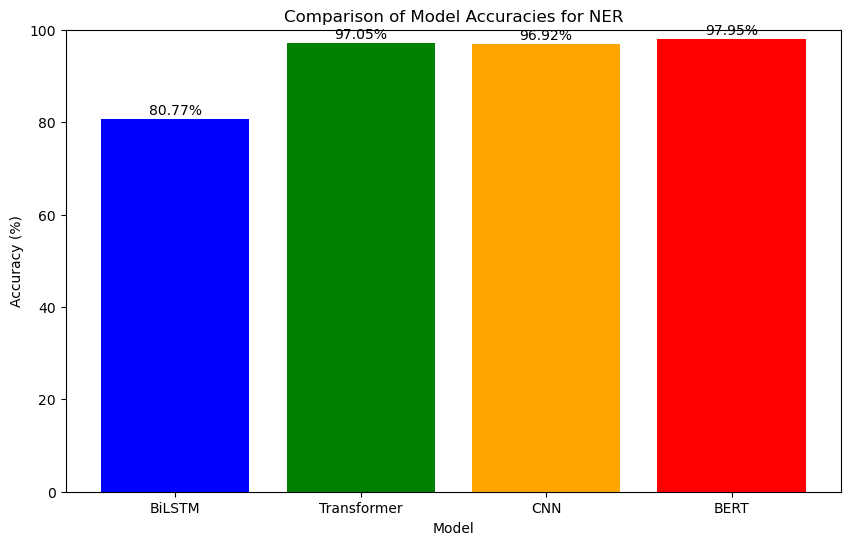

In [1]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
models = ['BiLSTM', 'Transformer', 'CNN', 'BERT']
accuracies = [80.77, 97.05, 96.92, 97.95]  # Accuracy percentages

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies for NER')
plt.ylim(0, 100)  # Set y-axis limit

# Display the accuracy values on top of each bar
for i in range(len(models)):
    plt.text(i, accuracies[i] + 1, f'{accuracies[i]:.2f}%', ha='center')

# Show the plot
plt.show()


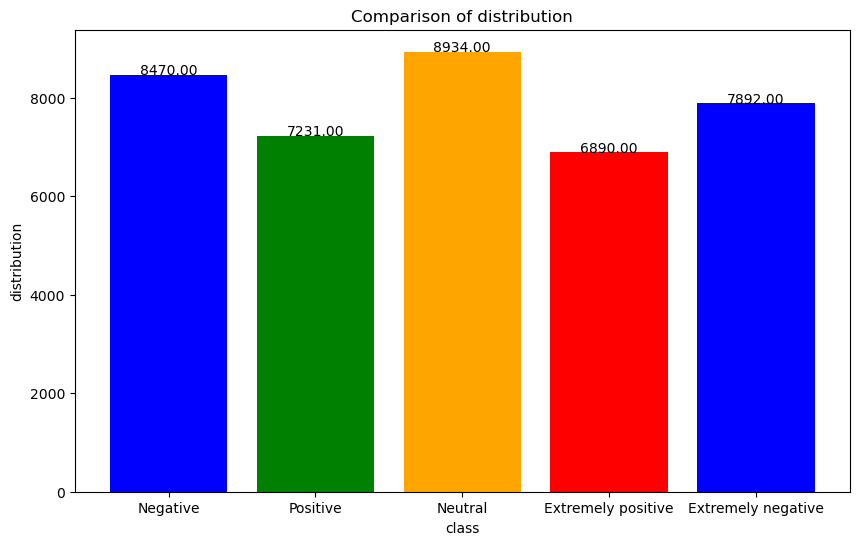

In [5]:
import matplotlib.pyplot as plt

# Model names and corresponding accuracies
models = ['Negative', 'Positive', 'Neutral', 'Extremely positive', 'Extremely negative']
accuracies = [8470, 7231,8934 , 6890,7892]  # Accuracy percentages

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])

# Add labels and title
plt.xlabel('class')
plt.ylabel('distribution')
plt.title('Comparison of distribution')


# Display the accuracy values on top of each bar
for i in range(len(models)):
    plt.text(i, accuracies[i] + 1, f'{accuracies[i]:.2f}', ha='center')

# Show the plot
plt.show()
